<a href="https://colab.research.google.com/github/MohamedAbuAmira/ML-DL-Examples/blob/master/CNN_model_Chest_X_Ray_classifier_(Pneumonia).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**classify images of Chest X-Ray Images by using transfer learning from a pre-trained network.**

the general machine learning workflow.

* Examine and understand the data
* Build an input pipeline, in this case using Keras ImageDataGenerator
* Compose the model
** Load in the pretrained base model (and pretrained weights)
** Stack the classification layers on top
* Train the model
* Evaluate model

In [1]:
#pip install -q tf-nightly

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
from vb100_utils import *
from shutil import copyfile
import shutil
import glob

`vb100_utils` from https://github.com/vb100/Pneumonia-X-Rays-of-Human-Lungs-AI-project/blob/master/vb100_utils.py

# Data preprocessing

## Data download

First I will download data from Kaggle. The dataset link is https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [4]:
#first I get my API, kaggle.json, then get the dataset API, and is:
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [5]:
from google.colab import files
files.upload()      #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedtayser","key":"2d27b20b0fbd11d6c0066e3997681dab"}'}

In [6]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json


kaggle.json


In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:30<00:00, 33.1MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.8MB/s]


In [8]:
!unzip -q chest-xray-pneumonia.zip -d .

!ls

chest_xray		  kaggle.json  sample_data
chest-xray-pneumonia.zip  __pycache__  vb100_utils.py


In [9]:
#%rm -rf chest_xray #delet folder
!rm chest-xray-pneumonia.zip #delet zip file


Befor go to disply and preprocessing images, firt I should show the files dictrory and make some changes.

In [10]:
# .....................................Data Folder System-------------------------------------------------
# chest_xray/
# -- test/
# ---- NORMAL/
# ------ <>.jpeg
# ---- PNEUMONIA/
# ------ <>_virus_<>.jpeg
# ------ <>_bacteria_<>.jpeg


# -- train/
# ---- NORMAL/
# ------ <>.jpeg
# ---- PNEUMONIA/
# ------ <>_bacteria_<>.jpeg
# ------ <>_virus_<>.jpeg

# -- val/
# ---- NORMAL/
# ------ <>.jpeg
# ---- PNEUMONIA/
# ------ <>_bacteria_<>.jpeg

We see that in `PNEUMONIA` folder there are two kinds of images, one for virus, and the second for bacteria. Bacteria and viruses are what cause pneumonia; so that here are to categorical. I want to predict what if the patient have:
* Bacterial pneumonia, or
* virus pneumonia, or
* Not (Normal)


Note that every image name in `PNEUMONIA` is labeled with virus or bacteria.


So I will restructure all folders in all datasets (test, train, val) to be have three catagorical (or three folders), that are:
 

In [11]:
# .....................................Data Folder System after restructure-------------------------------------------------
# chest_xray/
# -- test/
# ---- NORMAL/
# ------ <>.jpeg
# ---- BACTERIA/
# ------ <>_bacteria_<>.jpeg
#------VIRUS/
# ------ <>_virus_<>.jpeg

# -- train/
# ---- NORMAL/
# ------ <>.jpeg
# ---- BACTERIA/
# ------ <>_bacteria_<>.jpeg
#------VIRUS/
# ------ <>_virus_<>.jpeg

# -- val/
# ---- NORMAL/
# ------ <>.jpeg
# ---- BACTERIA/
# ------ <>_bacteria_<>.jpeg

In [12]:
# CONSTANTS FOR DIRECTORIES
TRAIN_DIR = 'chest_xray/train'
VALID_DIR = 'chest_xray/val'
TEST_DIR = 'chest_xray/test'
LIST_DIRS = [TRAIN_DIR, VALID_DIR, TEST_DIR]
POSITIVE_CLASS = 'NORMAL'
ABSTRACT_CLASS = 'PNEUMONIA'

IMAGE_FORMAT = 'jpeg'


In [13]:

if abstract_class_exists(ABSTRACT_CLASS, LIST_DIRS):
    structure_origin_data(LIST_DIRS, IMAGE_FORMAT, POSITIVE_CLASS)

classes = classes_for_each_set(LIST_DIRS)

print('Catched classes for the model:\n{}'.format(classes))

Performing raw data restructuring. Please wait.

Current Working Directory: /content

*** Handling workspace: chest_xray/train ***
| Folders found:
|| ['/content/chest_xray/train/PNEUMONIA', '/content/chest_xray/train/NORMAL']

| Entering to: /content/chest_xray/train/PNEUMONIA
||| Unique Classes Found: ['VIRUS', 'BACTERIA']
||| Files found in total: 3875
--> VIRUS = 1345
|||--> Filelist for VIRUS is created.
|||| Successfully created the directory for VIRUS on /content/chest_xray/train/VIRUS
--> BACTERIA = 2530
|||--> Filelist for BACTERIA is created.
|||| Successfully created the directory for BACTERIA on /content/chest_xray/train/BACTERIA

| Entering to: /content/chest_xray/train/NORMAL
||| Unique Classes Found: ['NORMAL']
||| Files found in total: 1341
--> NORMAL = 1341
|||--> Filelist for NORMAL is created.

*** Handling workspace: chest_xray/val ***
| Folders found:
|| ['/content/chest_xray/val/PNEUMONIA', '/content/chest_xray/val/NORMAL']

| Entering to: /content/chest_xray/val/

In [14]:
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 5216 files belonging to 3 classes.


In [15]:
len(train_dataset)

163

In [16]:
class_names = train_dataset.class_names
class_names

['BACTERIA', 'NORMAL', 'VIRUS']

In [17]:
validation_dataset = image_dataset_from_directory(VALID_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 16 files belonging to 2 classes.


In [18]:
len(validation_dataset)

1

In [19]:
test_dataset = image_dataset_from_directory(TEST_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 624 files belonging to 3 classes.


In [20]:
for image, labels in train_dataset.take(1):
  first_image = image[0]
  first_label= labels[0]

Text(0.5, 1.0, 'VIRUS')

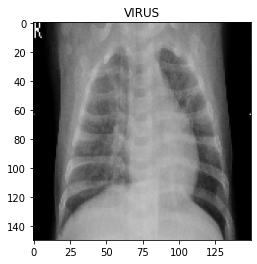

In [21]:
plt.imshow(first_image.numpy().astype("uint8"))
plt.title(class_names[first_label])

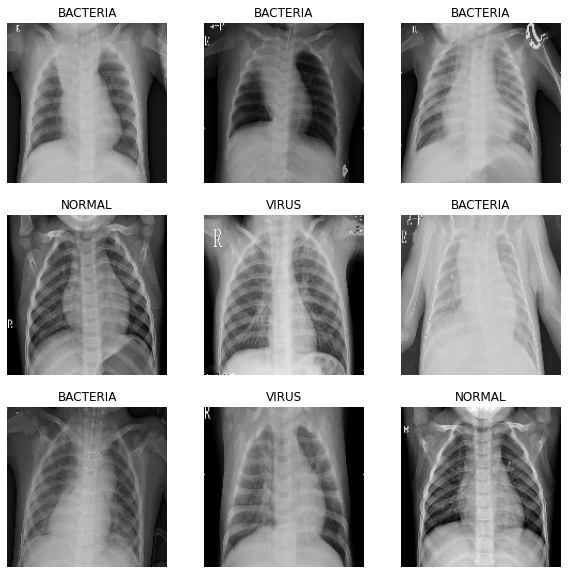

In [22]:
# disply 

#take one batch, 32 items

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Use data augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

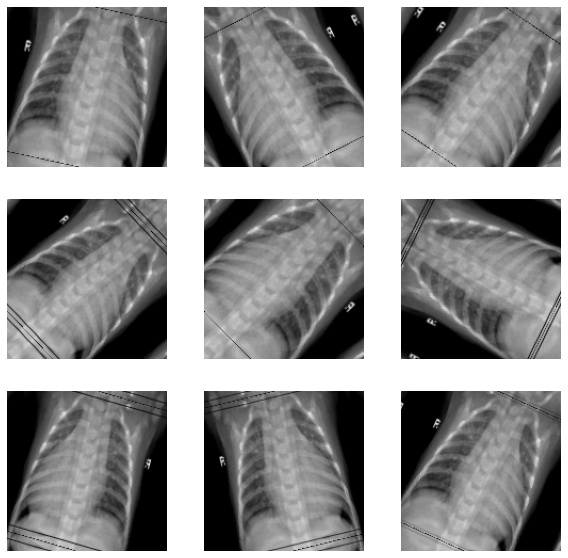

In [25]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescale pixel values

In [26]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [27]:
# Note: Alternatively, you could rescale pixel values from [0,255] to [-1, 1] using a Rescaling layer.


rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Create the base model from the pre-trained convnets

In [28]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

83689472/83683744 [==============================] - 1s 0us/step


**This feature extractor converts each 160x160x3 image into a 5x5x2048**

In [29]:
#  see what it does to an example batch of images

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


# Feature extraction

will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

## Freeze the convolutional base

In [30]:
base_model.trainable = False


## Important note about BatchNormalization layers

Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning

When you set `layer.trainable = False`, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model the model has learned

In [31]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to a single 2048-element vector per image

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [33]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


**Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.**

In [34]:
inputs=tf.keras.Input(shape=IMG_SHAPE)

x=data_augmentation(inputs)
x=preprocess_input(x)

x=base_model(x, training=False)

x=global_average_layer(x)
x=tf.keras.layers.Dropout(0.20)(x)
outputs=prediction_layer(x)

model=tf.keras.Model(inputs, outputs)

## Compile the model

In [35]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

In [37]:
print(len(model.trainable_variables))

2


## Train the model

In [38]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 0s 2ms/step - loss: 1.2148 - accuracy: 0.1250


In [39]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.21
initial accuracy: 0.12


In [40]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
163/163 [==============================] - 29s 178ms/step - loss: 1.0058 - accuracy: 0.5257 - val_loss: 0.8778 - val_accuracy: 0.7500
Epoch 2/10
163/163 [==============================] - 29s 176ms/step - loss: 0.9176 - accuracy: 0.6447 - val_loss: 0.8860 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 30s 181ms/step - loss: 0.8853 - accuracy: 0.6777 - val_loss: 0.8730 - val_accuracy: 0.6875
Epoch 4/10
163/163 [==============================] - 29s 179ms/step - loss: 0.8636 - accuracy: 0.6990 - val_loss: 0.8788 - val_accuracy: 0.6875
Epoch 5/10
163/163 [==============================] - 29s 179ms/step - loss: 0.8516 - accuracy: 0.7136 - val_loss: 0.8677 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 30s 182ms/step - loss: 0.8420 - accuracy: 0.7147 - val_loss: 0.8668 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 29s 181ms/step - loss: 0.8437 - accuracy: 0.7143 - val_loss: 0.8682 - val_ac

## Learning curves

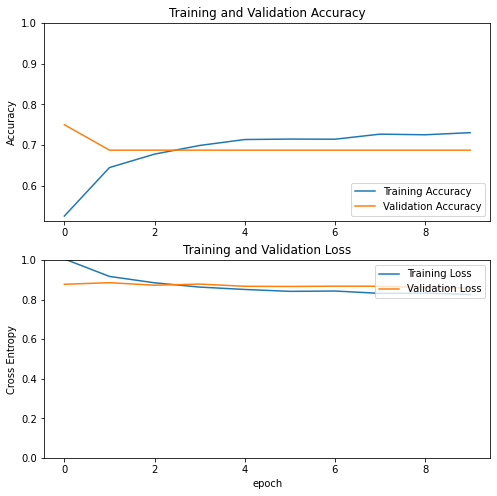

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

***Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.***


## Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training

In [42]:
base_model.trainable = True


In [43]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
'''
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
  '''

Number of layers in the base model:  132


'\n# Fine-tune from this layer onwards\nfine_tune_at = 100\n\n# Freeze all the layers before the `fine_tune_at` layer\nfor layer in base_model.layers[:fine_tune_at]:\n  layer.trainable =  False\n  '

# Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [44]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [45]:
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

In [46]:
len(model.trainable_variables)


156

## Continue training the model

In [47]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
163/163 [==============================] - 51s 312ms/step - loss: 0.7942 - accuracy: 0.7536 - val_loss: 0.8831 - val_accuracy: 0.6250
Epoch 11/20
163/163 [==============================] - 50s 306ms/step - loss: 0.7704 - accuracy: 0.7774 - val_loss: 0.9145 - val_accuracy: 0.6250
Epoch 12/20
163/163 [==============================] - 50s 306ms/step - loss: 0.7590 - accuracy: 0.7882 - val_loss: 0.9239 - val_accuracy: 0.5625
Epoch 13/20
163/163 [==============================] - 50s 307ms/step - loss: 0.7531 - accuracy: 0.7947 - val_loss: 0.9151 - val_accuracy: 0.6250
Epoch 14/20
163/163 [==============================] - 50s 306ms/step - loss: 0.7492 - accuracy: 0.7970 - val_loss: 0.9479 - val_accuracy: 0.5625
Epoch 15/20
163/163 [==============================] - 50s 307ms/step - loss: 0.7465 - accuracy: 0.8000 - val_loss: 0.8754 - val_accuracy: 0.6250
Epoch 16/20
163/163 [==============================] - 50s 307ms/step - loss: 0.7423 - accuracy: 0.8046 - val_loss: 1.0100 -

In [48]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

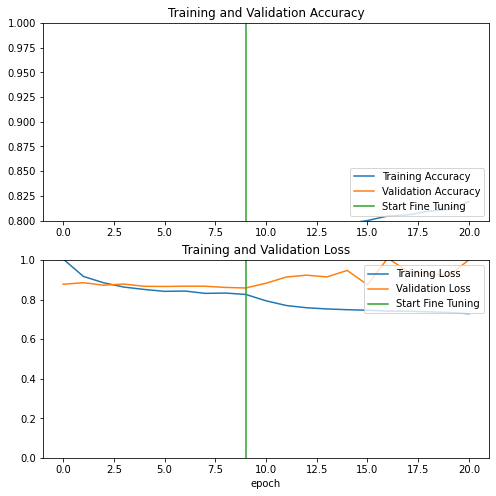

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

In [50]:
# Finaly you can verify the performance of the model on new data using test set.

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

20/20 [==============================] - 2s 110ms/step - loss: 0.6929 - accuracy: 0.8558
Test accuracy : 0.8557692170143127


In [51]:
for image_batch, label_batch in test_dataset:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break


Image batch shape:  (32, 150, 150, 3)
Label batch shape:  (32,)


In [52]:

class_names=np.asarray(class_names)
class_names

array(['BACTERIA', 'NORMAL', 'VIRUS'], dtype='<U8')

In [53]:


# Run the image batch through the model and convert the indices to class names.

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [54]:
predicted_batch

array([[6.0897272e-02, 9.3683273e-01, 2.2699509e-03],
       [1.3316622e-06, 9.9999785e-01, 7.7950858e-07],
       [7.7170879e-01, 2.2039509e-01, 7.8960629e-03],
       [9.9988711e-01, 3.9059441e-06, 1.0895932e-04],
       [1.5226367e-09, 9.9999988e-01, 1.1196544e-07],
       [7.0499176e-01, 5.3446267e-02, 2.4156202e-01],
       [5.6799524e-02, 9.3299580e-01, 1.0204756e-02],
       [2.5646191e-02, 9.5761633e-01, 1.6737400e-02],
       [2.1912150e-07, 9.9999595e-01, 3.8696617e-06],
       [5.2454430e-03, 9.8692387e-01, 7.8307502e-03],
       [6.0596058e-06, 4.8237698e-09, 9.9999392e-01],
       [5.3372310e-04, 4.9620922e-08, 9.9946624e-01],
       [9.9997520e-01, 8.8727727e-11, 2.4762523e-05],
       [9.9876356e-01, 1.1262232e-05, 1.2251404e-03],
       [5.5408832e-06, 7.5768454e-05, 9.9991870e-01],
       [9.9223260e-05, 9.9933225e-01, 5.6845718e-04],
       [9.9965346e-01, 9.2539101e-12, 3.4657161e-04],
       [1.3113519e-02, 2.5199885e-03, 9.8436654e-01],
       [5.2861968e-04, 6.234

In [55]:
predicted_id

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 0, 2, 1, 0, 2, 2, 1, 1, 1,
       0, 0, 0, 0, 2, 0, 1, 1, 0, 2])

In [56]:
predicted_label_batch

array(['NORMAL', 'NORMAL', 'BACTERIA', 'BACTERIA', 'NORMAL', 'BACTERIA',
       'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'VIRUS', 'VIRUS',
       'BACTERIA', 'BACTERIA', 'VIRUS', 'NORMAL', 'BACTERIA', 'VIRUS',
       'VIRUS', 'NORMAL', 'NORMAL', 'NORMAL', 'BACTERIA', 'BACTERIA',
       'BACTERIA', 'BACTERIA', 'VIRUS', 'BACTERIA', 'NORMAL', 'NORMAL',
       'BACTERIA', 'VIRUS'], dtype='<U8')

In [57]:
label_id= label_batch.numpy()
label_id

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 2, 1, 0, 1, 2, 1, 1, 1,
       0, 0, 0, 2, 2, 0, 1, 1, 0, 2], dtype=int32)

In [58]:
# no. of True classifed labels in that batch
sum(predicted_id == label_id)

28

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

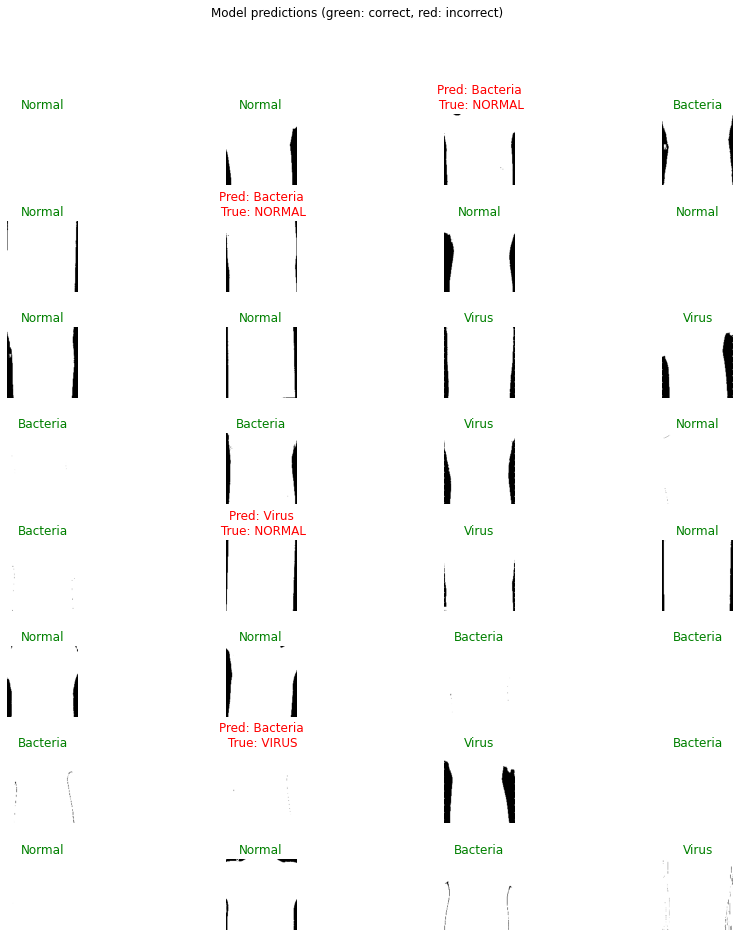

In [60]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(8,4,n+1)
  plt.imshow(image_batch[n])
  

    
  if predicted_id[n] == label_id[n]: 
    color = "green"
    plt.title(predicted_label_batch[n].title(), color=color)
  else: 
    color= "red"
    plt.title("Pred: {}\n True: {}".format(predicted_label_batch[n].title(), class_names[label_id[n]]), 
              color=color)

  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Save the model

In [61]:

# Save the Model Weights
model.save_weights('Pneumonia-X-Rays_weights.h5')

# Save the Model to JSON
model_json = model.to_json()
with open('Pneumonia-X-Rays.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the disk.')

Model saved to the disk.


explains from

https://www.tensorflow.org/tutorials/images/transfer_learning#top_of_page